In [1]:
# Repeated - delete this part when combining with previous section
import pandas as pd

# Read your Excel file
bank = pd.read_csv("bank.csv",sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [2]:
print("Statistics of pdays after grouping by poutcome:")
print(bank.groupby('poutcome')['pdays'].describe())
# All the unknown are due to client was not previously contacted
# Thus, unknown outcome of the previous marketing campaign

Statistics of pdays after grouping by poutcome:
           count        mean         std  min     25%    50%    75%    max
poutcome                                                                  
failure    490.0  243.167347  116.559071  7.0  161.25  234.5  340.0  871.0
other      197.0  219.385787  119.016391  2.0  126.00  187.0  330.0  761.0
success    129.0  163.713178   93.643789  1.0   94.00  152.0  187.0  541.0
unknown   3705.0   -1.000000    0.000000 -1.0   -1.00   -1.0   -1.0   -1.0


All the unknown are due to client was not previously contacted. Thus, unknown outcome of the previous marketing campaign.

In [3]:
# Encoding
# Categorical:	job, marital, education, default, housing, loan, contact, month, poutcome, y

# 1. Handle for pdays
# New variable: never contacted 'pdays_never_contacted'
bank['pdays_never_contacted'] = (bank['pdays'] == -1).astype(int)

# 2. Create contact_status combining pdays and poutcome
def contact_status(row):
    if row['pdays_never_contacted'] == 1:
        return 'never_contacted'
    else:
        return f'prev_{row["poutcome"]}'

bank['contact_status'] = bank.apply(contact_status, axis=1)

# 3. Drop/Handle Columns Not Useful for Prediction
### During the modelling, we need to drop the duration,
### If duration is long → predict Yes.
### However, before calling a new client, we don't know how long the call will last.
bank = bank.drop(columns=['pdays', 'poutcome', 'day', 'duration'])

# 4. Encode binary columns
binary_cols = ['default', 'housing', 'loan', 'y']
for col in binary_cols:
    bank[col] = bank[col].map({'no': 0, 'yes': 1})


# 5. For categorical variables except month (Use One-hot Encoding)
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'contact_status']
bank_encoded = pd.get_dummies(bank, columns=categorical_cols, drop_first=False)

# 6. Save category mappings for reference
# For month and contact_status only (others will be obvious from one-hot columns)
month_mapping = {month: f'month_{month}' for month in bank['month'].unique()}
contact_status_mapping = {status: f'contact_status_{status}' for status in bank['contact_status'].unique()}

# Convert mappings to CSV
mapping_rows = []
for category, code in month_mapping.items():
    mapping_rows.append({'Column': 'month', 'Category': category, 'Code': code})
for category, code in contact_status_mapping.items():
    mapping_rows.append({'Column': 'contact_status', 'Category': category, 'Code': code})

mapping_bank_encoded = pd.DataFrame(mapping_rows)
mapping_bank_encoded.to_csv("categorical_mappings.csv", index=False)
print("Categorical mappings saved to categorical_mappings.csv")


# 7. Save the fully encoded bank data
bank_encoded.to_csv("bank_encoded.csv", index=False)
print("Clean dataset saved as bank_encoded.csv")

# Preview
bank_encoded.head()

Categorical mappings saved to categorical_mappings.csv
Clean dataset saved as bank_encoded.csv


,age,default,balance,housing,loan,campaign,previous,y,pdays_never_contacted,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,contact_status_never_contacted,contact_status_prev_failure,contact_status_prev_other,contact_status_prev_success
0,30,0,1787,0,0,1,0,0,1,False,...,False,False,False,False,True,False,True,False,False,False
1,33,0,4789,1,1,1,4,0,0,False,...,False,False,True,False,False,False,False,True,False,False
2,35,0,1350,1,0,1,1,0,0,False,...,False,False,False,False,False,False,False,True,False,False
3,30,0,1476,1,1,4,0,0,1,False,...,True,False,False,False,False,False,True,False,False,False
4,59,0,0,1,0,1,0,0,1,False,...,False,False,True,False,False,False,True,False,False,False


In [4]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = bank_encoded.drop('y', axis=1)
Y = bank_encoded['y']

# Identify numeric columns to scale
numeric_features = ['age', 'balance', 'campaign', 'previous']

# Split into training and testing sets
X_train_unscaled, X_test_unscaled, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.3, random_state = 11, stratify = Y)

# Initialize scaler Z-score standardization
scaler = StandardScaler()

# Copy unscaled data to preserve original values
X_train_scaled = X_train_unscaled.copy()
X_test_scaled = X_test_unscaled.copy()

# Apply scaling only to numeric columns
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

print("The data have been standardized and split into training and test sets.")

# save split data and scaler
import joblib
joblib.dump(scaler, "scaler.pkl")

# Save both scaled and unscaled splits
joblib.dump({
    'X_train_unscaled': X_train_unscaled,
    'X_test_unscaled': X_test_unscaled,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'Y_train': Y_train,
    'Y_test': Y_test
}, "data_splits.pkl")

print("Scaler and both scaled/unscaled data splits saved successfully.")

The data have been standardized and split into training and test sets.
Scaler and both scaled/unscaled data splits saved successfully.


# Decision Tree Model

## Step 1: Load the required libraries and prepare data

In [5]:
import pandas as pd
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    confusion_matrix,
    matthews_corrcoef,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    auc,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn import tree

**X data**

Use unscaled data since Decision Tree Modeling is insensitive to feature scale, and unscaled data are more interpretable.


In [6]:
try:
    data_splits = joblib.load("data_splits.pkl")
    X_train = data_splits['X_train_unscaled']
    X_test = data_splits['X_test_unscaled']
    Y_train = data_splits['Y_train']
    Y_test = data_splits['Y_test']
    feature_names = X_train.columns.tolist()
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Unable to find data_splits.pkl file.")
    exit()

Data loaded successfully!


## Step 2: Hyperparameter Tuning using GridSearchCV

In [7]:
param_grid = {
    # 'criterion' determines the standard for measuring the "impurity" of a node
    'criterion': ['gini', 'entropy'],
    # 'splitter' determines how the split point is chosen at each node
    'splitter': ['best', 'random'],
    # 'max_depth' controls the maximum depth of the decision tree (prevent the model from overfitting)
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    # 'min_samples_split' specifies the minimum number of samples that an internal node must contain to be split
    'min_samples_split': [2, 5, 10, 20, 40],
    # 'min_samples_leaf' specifies the minimum number of samples a leaf node must contain
    'min_samples_leaf': [1, 2, 5, 10, 20],
    # 'min_impurity_decrease' is a threshold. A split will only be performed if the amount of impurity reduction that a split can bring is greater than or equal to this threshold
    'min_impurity_decrease': [0.0, 0.0001, 0.001],
    # 'class_weight' is used to deal with the problem of class imbalance. It can adjust the model's penalty for errors in different categories.
    'class_weight': [None, 'balanced'],
    # 'ccp_alpha' is a parameter alpha of Minimal Cost-Complexity Pruning
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.005, 0.01, 0.02]
}

# Initialize Decision Tree Classifier, set random_state for reproducibility
dtree = DecisionTreeClassifier(random_state=11)

# The Matthews Correlation Coefficient (MCC) calculation evenly considers the values ​​of all four confusion matrices.
# Therefore, even if one class is significantly more numerous than another, MCC provides a relatively balanced and reliable performance estimate.
# In contrast, Accuracy can be artificially inflated when the classes are imbalanced because it is primarily influenced by the correct prediction of the majority class.
mcc_scorer = make_scorer(matthews_corrcoef)

grid_search = GridSearchCV(estimator=dtree,
                           param_grid=param_grid,
                           cv=5,
                           scoring=mcc_scorer, # Optimize MCC score instead of Accuracy for this imbalance data
                           n_jobs=-1
                           )

# Execute grid search on training data
grid_search.fit(X_train, Y_train)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameter combination found: {best_params}")
print(f"Corresponding best MCC score (5-fold cross-validation average): {best_score:.4f}")

Best parameter combination found: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 40, 'splitter': 'random'}
Corresponding best MCC score (5-fold cross-validation average): 0.3192


## Step 3: Train Final Model with Best Parameters

In [8]:
print("\nTraining final Decision Tree model with best parameters")
best_dtree = DecisionTreeClassifier(**best_params, random_state=11)
best_dtree.fit(X_train, Y_train)


Training final Decision Tree model with best parameters


,criterion,'gini'
,splitter,'random'
,max_depth,3
,min_samples_split,40
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,11
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Step 4: Make Predictions on Test Set (Default Threshold)

In [9]:
print("\nMaking predictions on test set")
Y_pred = best_dtree.predict(X_test)


Making predictions on test set


In [10]:
y_pred_prob = best_dtree.predict_proba(X_test)[:, 1] # Get probability of predicting positive class (1)

## Step 5: Evaluate Model Performance (Default Threshold)




Evaluating model performance

Overall Accuracy (Default Threshold): 0.8895 (Note: May not be the best metric for imbalanced data)
Balanced Accuracy (Default Threshold): 0.5555

Confusion Matrix (Default Threshold):
[[1188   13]
 [ 137   19]]
         Predicted No   | Predicted Yes
Actual No |     1188    |     13    
Actual Yes|     137     |     19    

True Negatives (TN) (Default Threshold): 1188
False Positives (FP) (Default Threshold): 13
False Negatives (FN) (Default Threshold): 137
True Positives (TP) (Default Threshold): 19
Confusion matrix image saved as dt_confusion_matrix_default.png

Matthews Correlation Coefficient (MCC) (Default Threshold): 0.2333

Classification Report (Default Threshold):
              precision    recall  f1-score   support

      No (0)       0.90      0.99      0.94      1201
     Yes (1)       0.59      0.12      0.20       156

    accuracy                           0.89      1357
   macro avg       0.75      0.56      0.57      1357
weighted avg 

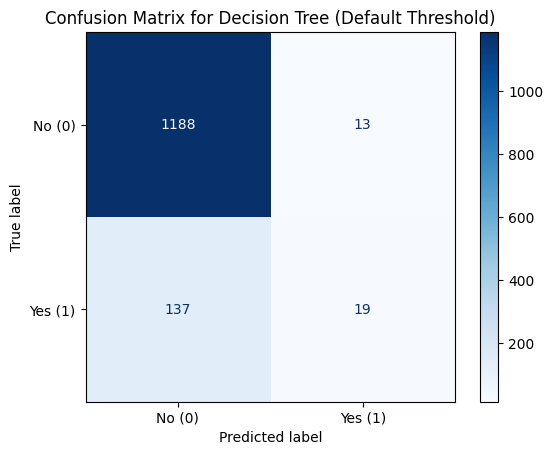

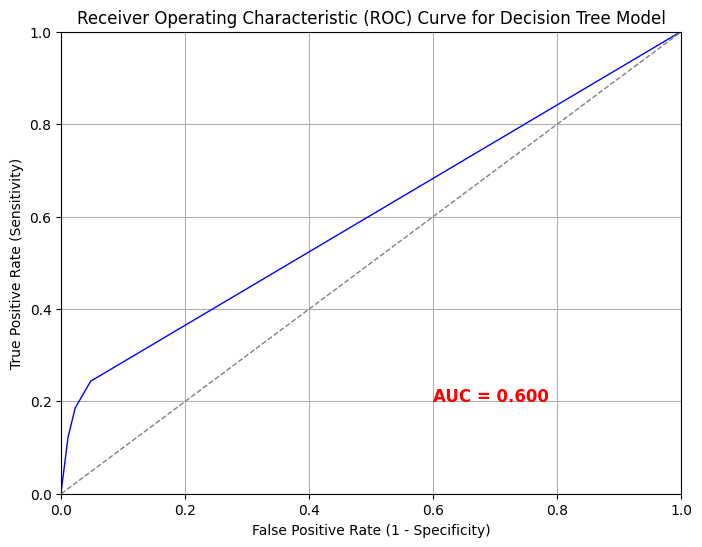

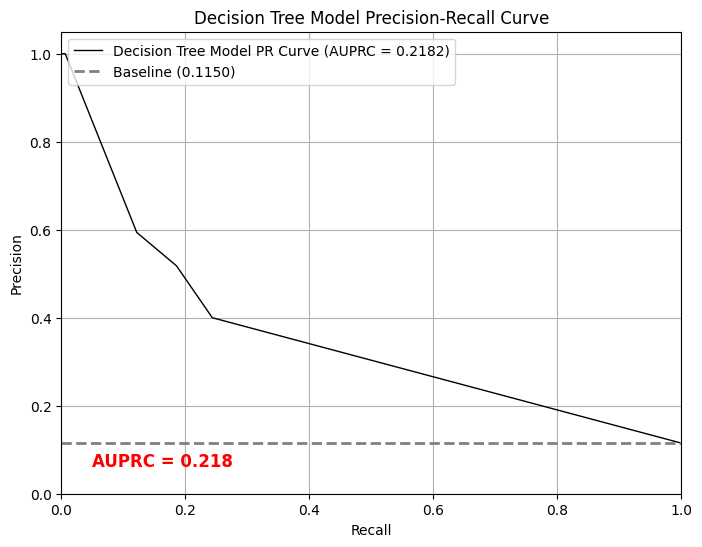

In [11]:
print("\nEvaluating model performance")

# 5.1 Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"\nOverall Accuracy (Default Threshold): {accuracy:.4f} (Note: May not be the best metric for imbalanced data)")

# 5.2 Balanced Accuracy
# Calculate the average of recall for each class, more suitable for imbalanced data
balanced_acc = balanced_accuracy_score(Y_test, Y_pred)
print(f"Balanced Accuracy (Default Threshold): {balanced_acc:.4f}")

# 5.3 Confusion Matrix
print("\nConfusion Matrix (Default Threshold):")
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

print(f"         Predicted No   | Predicted Yes")
print(f"Actual No |  {tn:^10} | {fp:^10}")
print(f"Actual Yes|  {fn:^10} | {tp:^10}")

print(f"\nTrue Negatives (TN) (Default Threshold): {tn}") # Correctly predicted as 'No'
print(f"False Positives (FP) (Default Threshold): {fp}") # Incorrectly predicted as 'Yes' (Type I Error)
print(f"False Negatives (FN) (Default Threshold): {fn}") # Incorrectly predicted as 'No' (Type II Error)
print(f"True Positives (TP) (Default Threshold): {tp}") # Correctly predicted as 'Yes'

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No (0)', 'Yes (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree (Default Threshold)")
plt.savefig("dt_confusion_matrix_default.png")
print("Confusion matrix image saved as dt_confusion_matrix_default.png")

# 5.4 Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"\nMatthews Correlation Coefficient (MCC) (Default Threshold): {mcc:.4f}")

# 5.5 Classification Report (Precision, Recall, F1-score)
print("\nClassification Report (Default Threshold):")
report = classification_report(Y_test, Y_pred, target_names=['No (0)', 'Yes (1)'])
print(report)
# Precision = TP / (TP + FP) : Proportion of actual Yes among predicted Yes
# Recall (Sensitivity) = TP / (TP + FN) : Proportion of correctly predicted Yes among actual Yes
# F1-score = 2 * (Precision * Recall) / (Precision + Recall) : Harmonic mean of Precision and Recall

precision_default = precision_score(Y_test, Y_pred, pos_label=1)
recall_default = recall_score(Y_test, Y_pred, pos_label=1)
f1_default = f1_score(Y_test, Y_pred, pos_label=1)

print(f"Precision (for class 'Yes'): {precision_default:.4f}")
print(f"Recall (for class 'Yes'):    {recall_default:.4f}")
print(f"F1-Score (for class 'Yes'):  {f1_default:.4f}")

# 5.6 Specificity
# Calculate the proportion of actual No samples that are correctly predicted as No
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"\nSpecificity (TNR) (Default Threshold): {specificity:.4f} (Measures ability to correctly identify negative class)")


# 5.7 ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

print(f"\nAUC (Area Under ROC Curve): {roc_auc:.4f} (Overall ability to distinguish positive and negative classes, closer to 1 is better)")


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=1, label=f'Decision Tree Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.text(0.6, 0.2, f'AUC = {roc_auc:.3f}', fontsize=12, color='red', weight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree Model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.savefig("dt_roc_curve.png")
print("ROC curve image saved as dt_roc_curve.png")


# 5.8 Precision Recall Curve and AUPRC
auprc = average_precision_score(Y_test, y_pred_prob)
print(f"Area under the PR curve (AUPRC): {auprc:.4f}")

precision, recall, thresholds_pr = precision_recall_curve(Y_test, y_pred_prob)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='black', lw=1, label=f'Decision Tree Model PR Curve (AUPRC = {auprc:.4f})')
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
plt.plot([0, 1], [no_skill, no_skill], color='gray', lw=2, linestyle='--',
         label=f'Baseline ({no_skill:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Model Precision-Recall Curve')
plt.text(0.05, 0.05, f'AUPRC = {auprc:.3f}',
         fontsize=12, color='red', weight='bold',
         horizontalalignment='left', verticalalignment='bottom',
         transform=plt.gca().transAxes)
plt.legend(loc="upper left")
plt.grid(True)
plt.savefig("dt_pc_curve.png")
print("PR curve image saved as dt_pc_curve.png")

## Step 6: Adjusting Threshold

In [12]:
# Calculate F1-Score for all possible thresholds
epsilon = 1e-7 # Avoid division by zero
f1_scores = (2 * precision * recall) / (precision + recall + epsilon)

# The `thresholds_pr` array has one less element than the `f1_scores` array
f1_scores_aligned = f1_scores[:-1]

# Find the index with the highest F1-Score
optimal_idx = np.argmax(f1_scores_aligned)

# Get the optimal threshold and corresponding P, R, F1 values
optimal_threshold = thresholds_pr[optimal_idx]
optimal_f1 = f1_scores_aligned[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

print(f"\nOptimal threshold (based on F1-Score): {optimal_threshold:.4f}")
print(f"  -> F1-Score at this threshold: {optimal_f1:.4f}")
print(f"  -> Precision at this threshold: {optimal_precision:.4f}")
print(f"  -> Recall at this threshold: {optimal_recall:.4f}")

# Plot the curves of P, R, F1 as the threshold changes
plt.figure(figsize=(10, 7))
plt.plot(thresholds_pr, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds_pr, f1_scores_aligned, 'r-', lw=2, label='F1-Score')
# Mark the location of the optimal threshold
plt.axvline(x=optimal_threshold, color='purple', lw=2, linestyle=':',
                label=f'Optimal threshold ({optimal_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-Score vs. Decision Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig("threshold_tuning_plot.png")
print("Image saved as'threshold_tuning_plot.png'")
plt.close()


Optimal threshold (based on F1-Score): 0.2871
  -> F1-Score at this threshold: 0.3028
  -> Precision at this threshold: 0.4000
  -> Recall at this threshold: 0.2436
Image saved as'threshold_tuning_plot.png'


## Step 7: Evaluate Model Performance (Optimal Threshold)


Evaluating model performance (with Optimal Threshold: 0.2871)

Overall Accuracy (Optimal Threshold): 0.8710 (Note: May not be the best metric for imbalanced data)
Balanced Accuracy (Optimal Threshold): 0.5981

Confusion Matrix (Optimal Threshold):
[[1144   57]
 [ 118   38]]
             Predicted No | Predicted Yes
Actual No |     1144    |     57    
Actual Yes|     118     |     38    

True Negatives (TN) (Optimal Threshold): 1144
False Positives (FP) (Optimal Threshold): 57
False Negatives (FN) (Optimal Threshold): 118
True Positives (TP) (Optimal Threshold): 38
Confusion matrix image saved as dt_confusion_matrix_optimal.png

Matthews Correlation Coefficient (MCC) (Optimal Threshold): 0.2452

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      No (0)       0.91      0.95      0.93      1201
     Yes (1)       0.40      0.24      0.30       156

    accuracy                           0.87      1357
   macro avg       0.65      0.6

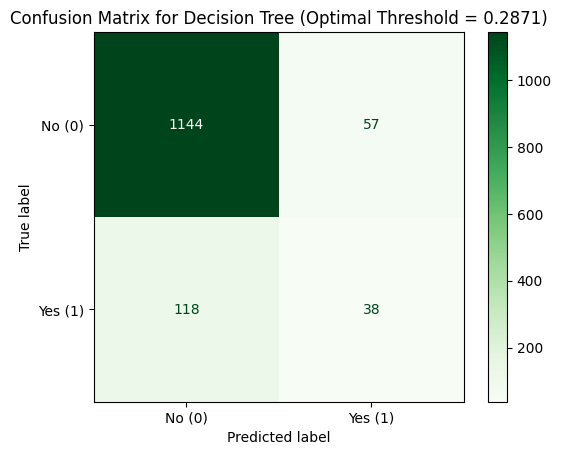

In [13]:
print(f"\nEvaluating model performance (with Optimal Threshold: {optimal_threshold:.4f})")

# Apply the optimal threshold to the probability to get the new category prediction
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# 7.1 Accuracy
accuracy_opt = accuracy_score(Y_test, y_pred_optimal)
print(f"\nOverall Accuracy (Optimal Threshold): {accuracy_opt:.4f} (Note: May not be the best metric for imbalanced data)")

# 7.2 Balanced Accuracy
# Calculate the average of recall for each class, more suitable for imbalanced data
balanced_acc_opt = balanced_accuracy_score(Y_test, y_pred_optimal)
print(f"Balanced Accuracy (Optimal Threshold): {balanced_acc_opt:.4f}")

# 7.3 Confusion Matrix
print("\nConfusion Matrix (Optimal Threshold):")
cm_opt = confusion_matrix(Y_test, y_pred_optimal, labels=best_dtree.classes_)
print(cm_opt)
tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()

print(f"             Predicted No | Predicted Yes")
print(f"Actual No |  {tn_opt:^10} | {fp_opt:^10}")
print(f"Actual Yes|  {fn_opt:^10} | {tp_opt:^10}")

print(f"\nTrue Negatives (TN) (Optimal Threshold): {tn_opt}") # Correctly predicted as 'No'
print(f"False Positives (FP) (Optimal Threshold): {fp_opt}") # Incorrectly predicted as 'Yes' (Type I Error)
print(f"False Negatives (FN) (Optimal Threshold): {fn_opt}") # Incorrectly predicted as 'No' (Type II Error)
print(f"True Positives (TP) (Optimal Threshold): {tp_opt}") # Correctly predicted as 'Yes'

# Visualize confusion matrix
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=['No (0)', 'Yes (1)'])
disp_opt.plot(cmap=plt.cm.Greens)
plt.title(f"Confusion Matrix for Decision Tree (Optimal Threshold = {optimal_threshold:.4f})")
plt.savefig("dt_confusion_matrix_optimal.png")
print("Confusion matrix image saved as dt_confusion_matrix_optimal.png")

# 7.4 Matthews Correlation Coefficient (MCC)
mcc_opt = matthews_corrcoef(Y_test, y_pred_optimal)
print(f"\nMatthews Correlation Coefficient (MCC) (Optimal Threshold): {mcc_opt:.4f}")

# 7.5 Classification Report (Precision, Recall, F1-score)
print("\nClassification Report (Optimal Threshold):")
report_opt = classification_report(Y_test, y_pred_optimal, target_names=['No (0)', 'Yes (1)'])
print(report_opt)

# 7.6 Specificity
# Calculate the proportion of actual No samples that are correctly predicted as No
specificity_opt = tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) > 0 else 0
print(f"\nSpecificity (TNR) (Optimal Threshold): {specificity_opt:.4f} (Measures ability to correctly identify negative class)")

## Step 8: Model Interpretation


Model interpretation

Feature Importances (Top 5):
                        Feature  Importance
45  contact_status_prev_success    0.712814
40                    month_oct    0.115273
0                           age    0.091193
2                       balance    0.032177
20             marital_divorced    0.025925
Feature importance plot saved as dt_feature_importances.png

Note: Feature importance indicates which features the model considers most useful for distinguishing the target variable when building the tree.
Decision tree visualization saved as dt_visualization_top3.png

Interpretation guide: Starting from the root node, each internal node represents a test condition on a feature,
splitting samples to the left child node (True) or right child node (False) based on the condition.
Leaf nodes represent the final predicted class ('class='), color intensity indicates purity.
'samples' is the number of samples reaching that node, 'value'=[No count, Yes count].



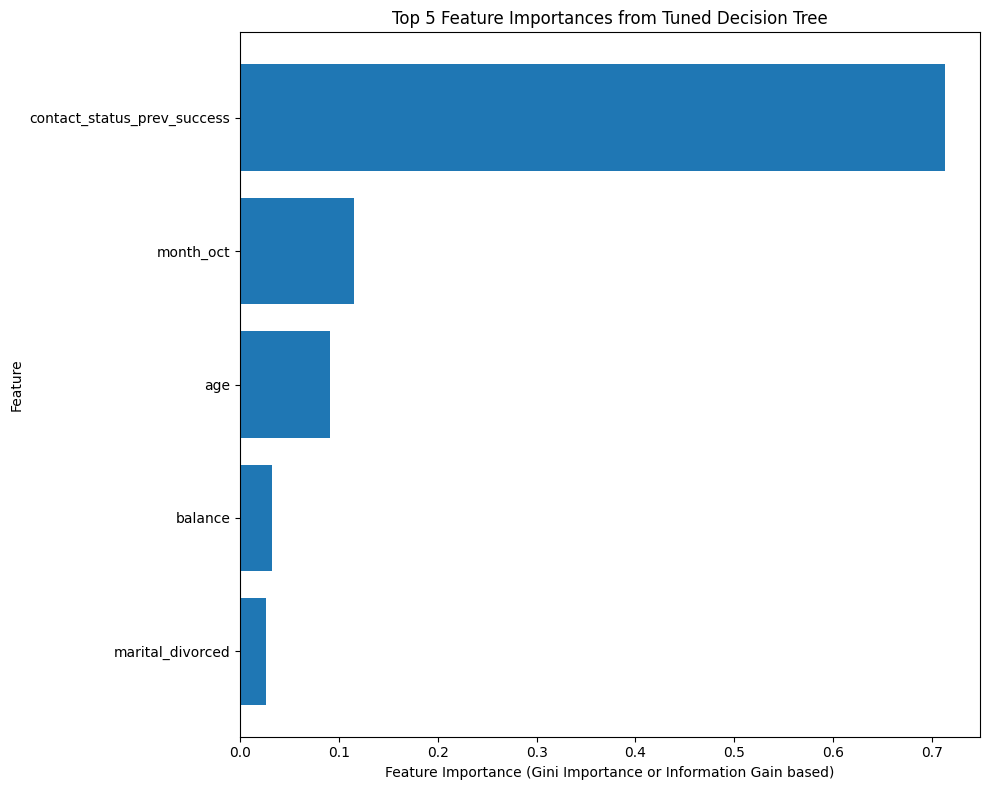

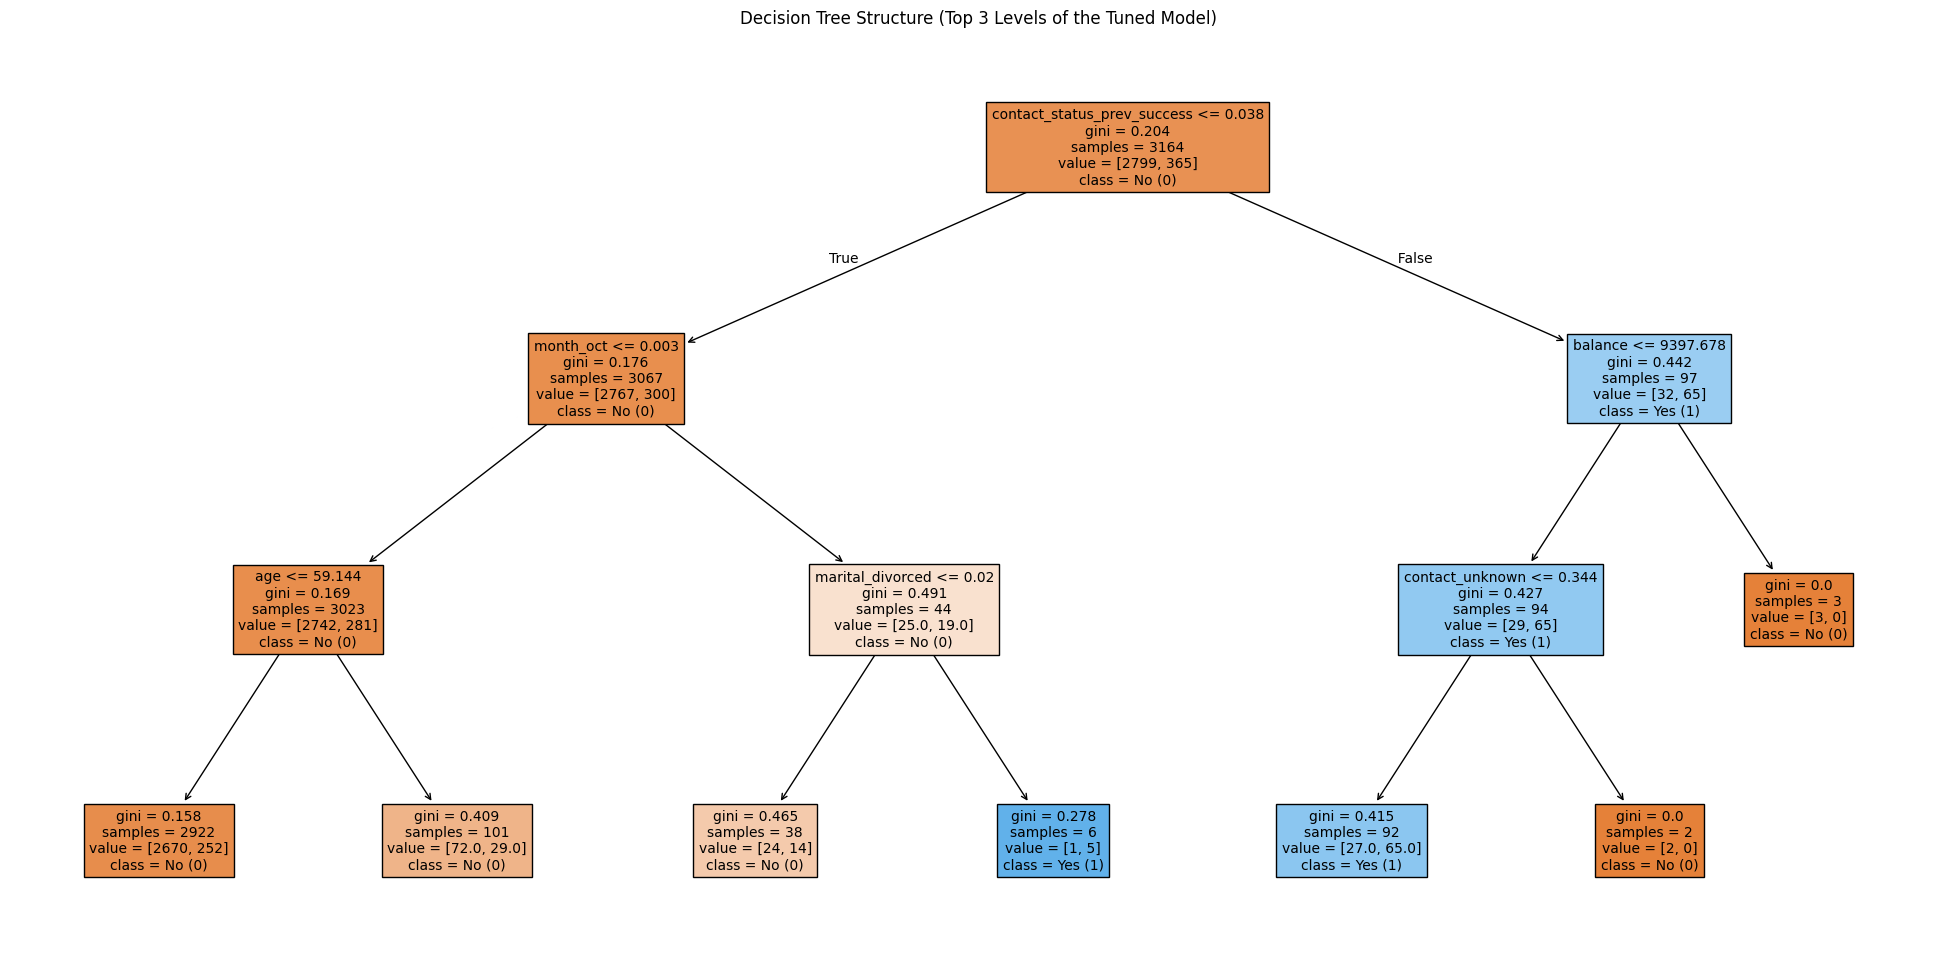

In [14]:
print("\nModel interpretation")

# 8.1 Feature Importances
# Calculated based on Gini impurity or Information Gain
importances = best_dtree.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Top 5):")
print(feature_importance_df.head(5))

# Visualize feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance (Gini Importance or Information Gain based)')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances from Tuned Decision Tree')
plt.tight_layout()
plt.savefig("dt_feature_importances.png")
print("Feature importance plot saved as dt_feature_importances.png")
print("\nNote: Feature importance indicates which features the model considers most useful for distinguishing the target variable when building the tree.")

# 8.2 Decision Tree Visualization
# Limit tree depth for better viewing and interpretation, e.g., max_depth=3
plt.figure(figsize=(25, 12))
best_depth_param = best_params.get('max_depth', None)
plot_depth = best_depth_param if best_depth_param is not None else 5

tree.plot_tree(best_dtree,
               feature_names=feature_names,
               class_names=['No (0)', 'Yes (1)'],
               filled=True, # color represents purity
               proportion=False, # display sample counts instead of proportions
               max_depth=plot_depth,
               fontsize=10)
plt.title(f"Decision Tree Structure (Top {plot_depth} Levels of the Tuned Model)")
plt.savefig(f"dt_visualization_top{plot_depth}.png")
print(f"Decision tree visualization saved as dt_visualization_top{plot_depth}.png")

note_dt = '''
Interpretation guide: Starting from the root node, each internal node represents a test condition on a feature,
splitting samples to the left child node (True) or right child node (False) based on the condition.
Leaf nodes represent the final predicted class ('class='), color intensity indicates purity.
'samples' is the number of samples reaching that node, 'value'=[No count, Yes count].
'''
print(note_dt)